Installing Requirements

In [19]:
!pip install -r requirements.txt

Import Required Libaries

In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

Limit display for ease of support

In [21]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)

In [22]:
!ls

csv_files  ds_report.pdf  main_notebook.ipynb  outputs	requirements.txt


Load Data from CSVs

In [23]:
# Defined a root folder for data files
DATA_DIR = "csv_files"

# locations of the data files 
trades_path = f"{DATA_DIR}/historical_data.csv"
fear_path   = f"{DATA_DIR}/fear_greed_index.csv"

# reading data from csv files
tr = pd.read_csv(trades_path, low_memory=False)
fr = pd.read_csv(fear_path, low_memory=False)

# Display the shape of the datasets to verify successful loading
print("Trades:", tr.shape)
print("Sentiment:", fr.shape)

Trades: (211224, 16)
Sentiment: (2644, 4)


CSV Prototyping

In [24]:
print("Columns in Trades DataFrame:")
for cols in tr.columns.tolist():
    print(cols)
    
print("\nColumns in Sentiment DataFrame:")
for cols in fr.columns.tolist():
    print(cols)

Columns in Trades DataFrame:
Account
Coin
Execution Price
Size Tokens
Size USD
Side
Timestamp IST
Start Position
Direction
Closed PnL
Transaction Hash
Order ID
Crossed
Fee
Trade ID
Timestamp

Columns in Sentiment DataFrame:
timestamp
value
classification
date


In [25]:
# Stripping whitespace from column names
tr.columns = [c.strip() for c in tr.columns]
fr.columns = [c.strip() for c in fr.columns]

In [26]:
# Identify the time column in trades data
time_col = None
for c in tr.columns:
    if "timestamp" in c.lower() or "time" in c.lower() or "date" in c.lower():
        time_col = c
        break

print("Time column =", time_col)

tr['trade_dt'] = pd.to_datetime(tr[time_col], errors='coerce')
tr['trade_date'] = tr['trade_dt'].dt.normalize()

Time column = Timestamp IST


In [27]:
# parsing greed data
fear_date_col = None
for c in fr.columns:
    if "date" in c.lower():
        fear_date_col = c
        break

print("Sentiment date column =", fear_date_col)

fr['fg_date'] = pd.to_datetime(fr[fear_date_col], errors='coerce').dt.normalize()

Sentiment date column = date


In [28]:
# SENTIMENT COLUMNS
classification_col = None
for c in fr.columns:
    if "class" in c.lower() or "label" in c.lower():
        classification_col = c
        break

if classification_col is None:
    classification_col = 'classification'

fr['Classification'] = fr[classification_col].astype(str)

# Numeric value
value_col = None
for c in fr.columns:
    if "value" in c.lower():
        value_col = c
        break

fr['fg_value'] = pd.to_numeric(fr[value_col], errors='coerce')

In [29]:
# Merging with daily trades
fr_small = fr[['fg_date','Classification','fg_value']].rename(columns={'fg_date':'date'})
merged = tr.merge(fr_small, left_on='trade_date', right_on='date', how='left')

print("Merged:", merged.shape)
merged.head()

Merged: (211224, 21)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,trade_dt,trade_date,date,Classification,fg_value
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,2024-02-12,Greed,70.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,2024-02-12,Greed,70.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,2024-02-12,Greed,70.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,2024-02-12,Greed,70.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,2024-02-12,Greed,70.0


PnL Parsing, Distribution, Lag Analysis, Segmentation

In [30]:
def find_col(df, keys):
    for c in df.columns:
        if any(k in c.lower() for k in keys):
            return c
    return None

pnl_col      = find_col(merged, ['pnl','profit','closed'])
size_col     = find_col(merged, ['size','qty','quantity'])
leverage_col = find_col(merged, ['lev','leverage'])
account_col  = find_col(merged, ['account','acc'])
side_col     = find_col(merged, ['side'])

print("PnL col:", pnl_col)
print("Size col:", size_col)
print("Leverage col:", leverage_col)
print("Account col:", account_col)
print("Side col:", side_col)

merged['closedPnL_num'] = pd.to_numeric(merged[pnl_col], errors='coerce') if pnl_col else np.nan
merged['size_num']      = pd.to_numeric(merged[size_col], errors='coerce') if size_col else np.nan
merged['leverage_num']  = pd.to_numeric(merged[leverage_col], errors='coerce') if leverage_col else np.nan

PnL col: Closed PnL
Size col: Size Tokens
Leverage col: None
Account col: Account
Side col: Side


SENTIMENT SCORE (USE NUMERIC IF AVAILABLE)

In [31]:
if merged['fg_value'].notna().any():
    merged['sentiment_score'] = merged['fg_value']
else:
    mapped = {'Extreme Fear':0,'Fear':1,'Neutral':2,'Greed':3,'Extreme Greed':4}
    merged['sentiment_score'] = merged['Classification'].map(mapped)


In [32]:
# aggregations

agg = merged.groupby('Classification').agg(
    num_trades=('closedPnL_num','count'),
    total_pnl=('closedPnL_num','sum'),
    avg_pnl=('closedPnL_num','mean'),
    win_rate=('closedPnL_num', lambda s: (s>0).mean())
).reset_index()

agg

,Classification,num_trades,total_pnl,avg_pnl,win_rate
0,Extreme Fear,2326,4.399937e+03,1.891632,0.292777
1,Extreme Greed,5621,1.156894e+06,205.816345,0.553282
2,Fear,13869,1.779226e+06,128.287950,0.381787
3,Greed,11292,6.096325e+05,53.988003,0.435707
4,Neutral,2756,7.465674e+04,27.088803,0.494920


/tmp/ipykernel_12612/265830927.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([merged.loc[merged['Classification']==lab,'closedPnL_num'].dropna()


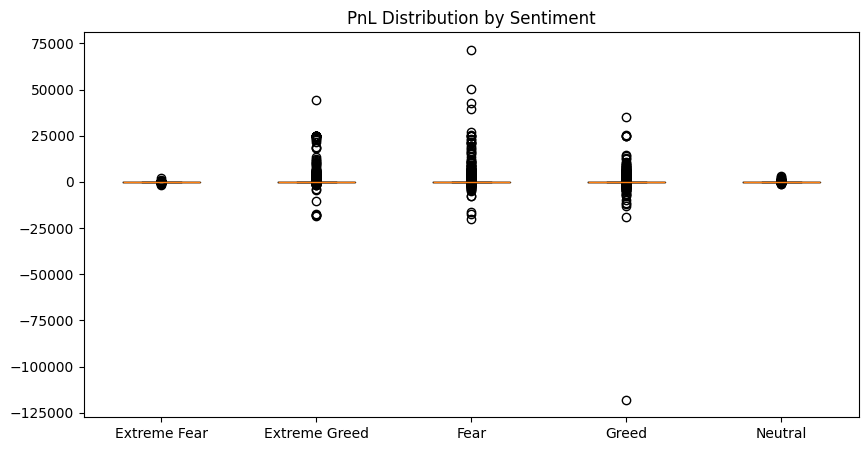

In [33]:
# Distribution plots
plt.figure(figsize=(10,5))
plt.boxplot([merged.loc[merged['Classification']==lab,'closedPnL_num'].dropna() 
             for lab in agg['Classification']], 
            labels=agg['Classification'])
plt.title("PnL Distribution by Sentiment")
plt.show()


Win Rate by Sentiment x Leverage Bucket

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,6))

heat = seg.pivot_table(
    index='lev_bucket',
    columns='Classification',
    values='win_rate'
)

sns.heatmap(heat, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Win Rate Heatmap by Sentiment × Leverage Bucket")

plt.tight_layout()
plt.savefig("outputs/winrate_heatmap.png")
plt.show()


NameError: name 'seg' is not defined

<Figure size 1200x600 with 0 Axes>

In [40]:
# SEGMENTATION BY LEVERAGE × SIDE × SENTIMENT

merged['lev_bucket'] = pd.cut(
    merged['leverage_num'].fillna(-1),
    bins=[-1, 0, 1, 2, 5, 10, 50, 100, 99999],
    labels=['Unknown','<=1','1-2','2-5','5-10','10-50','50-100','100+'],
    include_lowest=True
)

seg = merged.groupby(['lev_bucket','Side','Classification']).agg(
    trades=('closedPnL_num','count'),
    avg_pnl=('closedPnL_num','mean'),
    win_rate=('closedPnL_num', lambda s: (s>0).mean())
).reset_index()

seg.head()


/tmp/ipykernel_12612/464112237.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg = merged.groupby(['lev_bucket','Side','Classification']).agg(


,lev_bucket,Side,Classification,trades,avg_pnl,win_rate
0,Unknown,BUY,Extreme Fear,1168,-3.248825,0.062500
1,Unknown,BUY,Extreme Greed,1661,9.047055,0.311258
2,Unknown,BUY,Fear,7307,210.426466,0.338443
3,Unknown,BUY,Greed,5407,15.661324,0.296837
4,Unknown,BUY,Neutral,1020,12.484274,0.326471


Avg PnL by Sentiment × Side

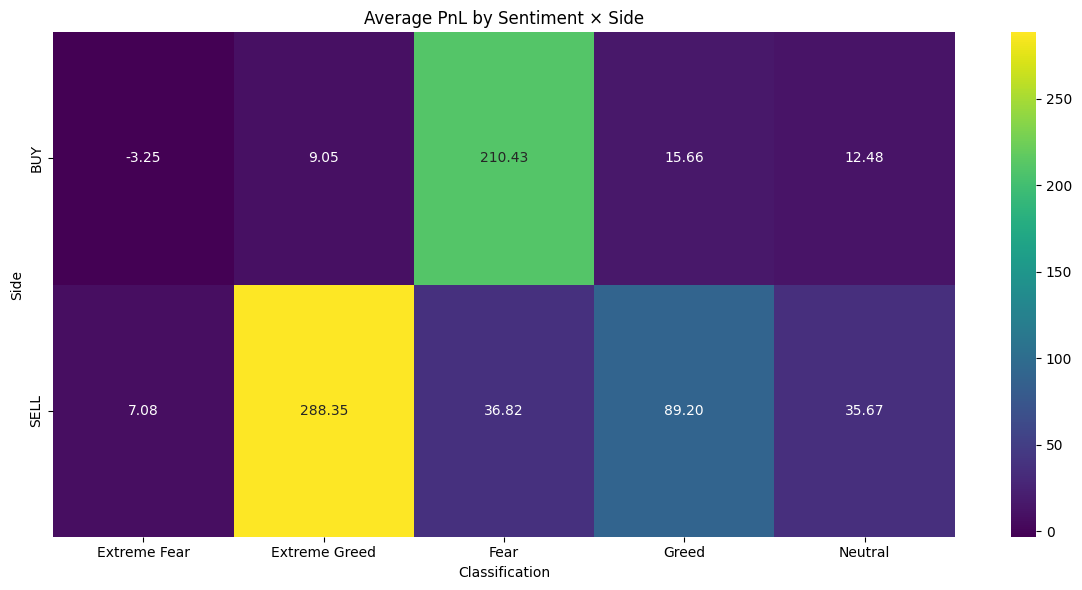

In [41]:
plt.figure(figsize=(12,6))

heat2 = seg.pivot_table(
    index='Side',
    columns='Classification',
    values='avg_pnl'
)

sns.heatmap(heat2, annot=True, cmap="viridis", fmt=".2f")
plt.title("Average PnL by Sentiment × Side")

plt.tight_layout()
plt.savefig("outputs/avgpnl_side_sentiment_heatmap.png")
plt.show()


Total Trades Across Sentiment Classes

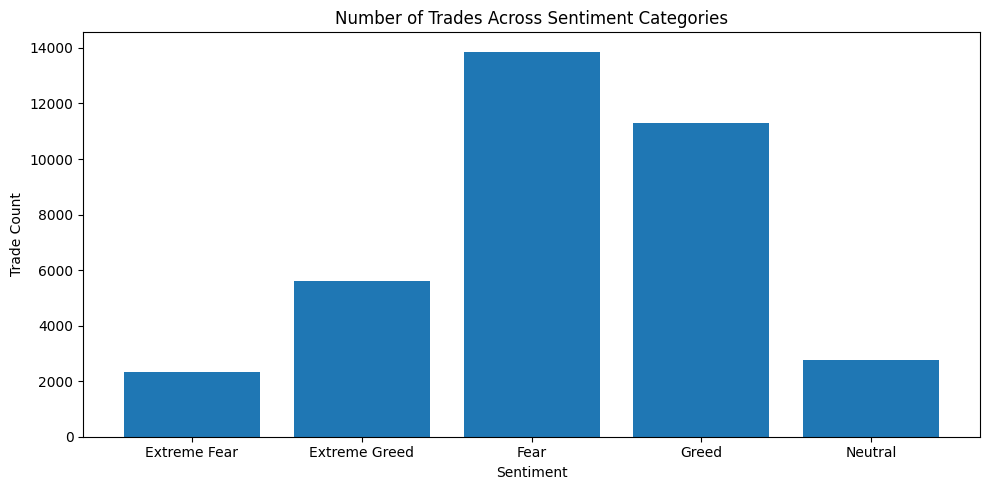

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(agg["Classification"], agg["num_trades"])
plt.title("Number of Trades Across Sentiment Categories")
plt.xlabel("Sentiment")
plt.ylabel("Trade Count")

plt.tight_layout()
plt.savefig("outputs/total_trades_by_sentiment.png")
plt.show()


Daily Mean PnL vs Daily Sentiment

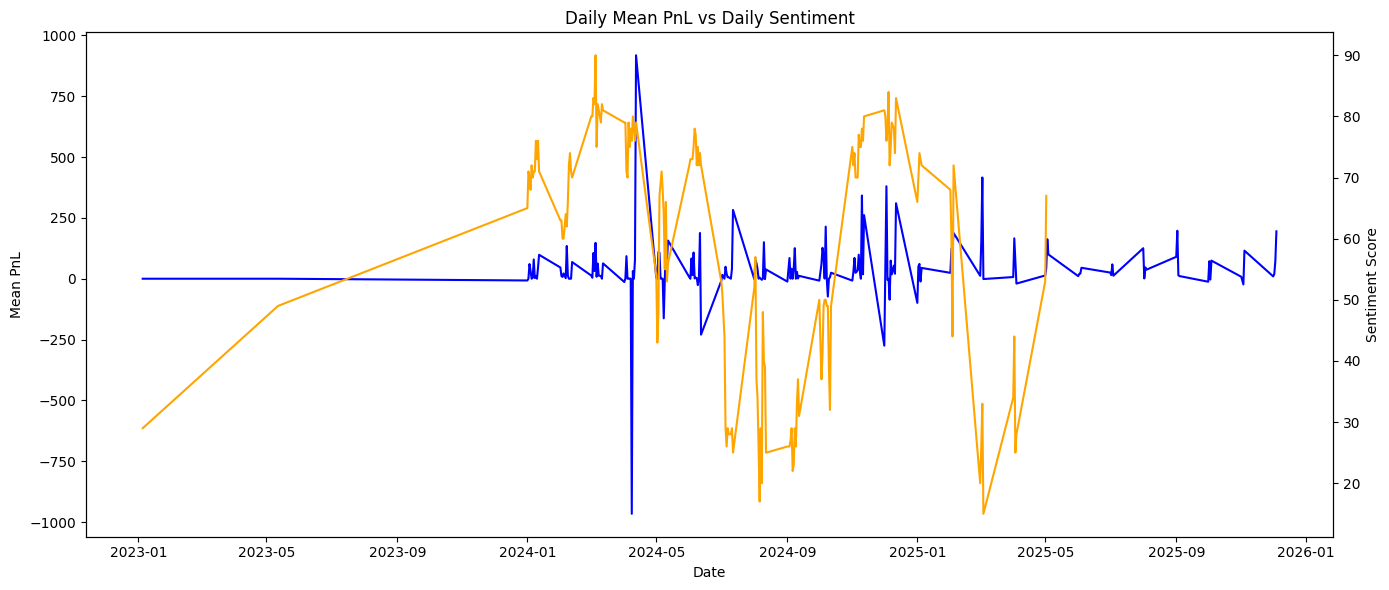

In [ ]:
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(daily["trade_date"], daily["mean_pnl"], label="Mean PnL", color='blue')
ax2 = ax1.twinx()
ax2.plot(daily["trade_date"], daily["mean_sentiment"], label="Sentiment", color='orange')

ax1.set_title("Daily Mean PnL vs Daily Sentiment")
ax1.set_xlabel("Date")
ax1.set_ylabel("Mean PnL")
ax2.set_ylabel("Sentiment Score")

fig.tight_layout()
plt.savefig("outputs/daily_pnl_vs_sentiment.png")
plt.show()


Event Windows Plot (Average Around Extreme Days)

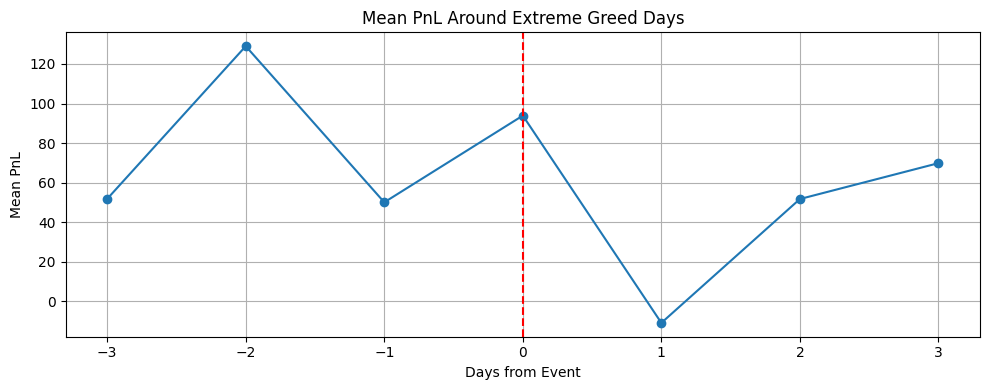

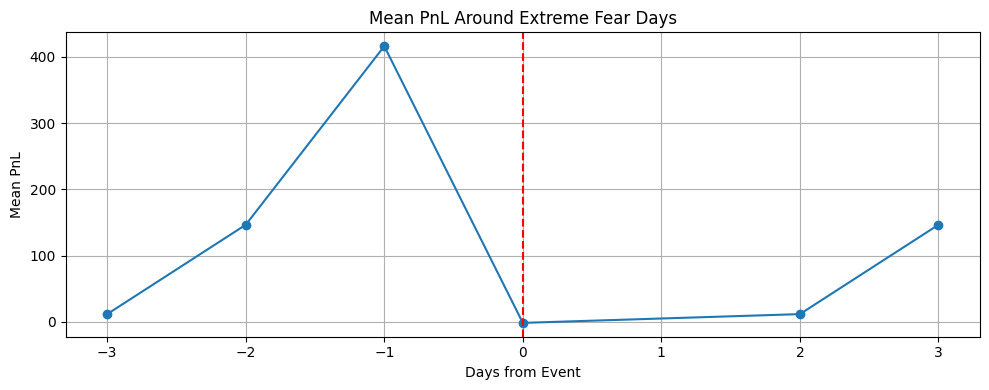

In [ ]:
def plot_event_window(df, title, filename):
    avg = df.groupby('relative').agg(mean_pnl=('mean_pnl','mean')).reset_index()

    plt.figure(figsize=(10,4))
    plt.plot(avg['relative'], avg['mean_pnl'], marker='o')
    plt.axvline(0, color='red', linestyle='--')
    plt.title(title)
    plt.xlabel("Days from Event")
    plt.ylabel("Mean PnL")
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_event_window(event_greed, "Mean PnL Around Extreme Greed Days", "outputs/extreme_greed_window.png")
plot_event_window(event_fear, "Mean PnL Around Extreme Fear Days",  "outputs/extreme_fear_window.png")


In [ ]:
# Lagged Correlation Analysis

daily = merged.groupby('trade_date').agg(
    mean_pnl=('closedPnL_num','mean'),
    mean_sentiment=('sentiment_score','mean')
).reset_index()

lag_corr = {}
for lag in range(8):
    temp = daily.copy()
    temp['sent_lag'] = temp['mean_sentiment'].shift(lag)
    temp = temp.dropna()
    lag_corr[lag] = temp['sent_lag'].corr(temp['mean_pnl'])

pd.DataFrame({"Lag": list(lag_corr.keys()), "Correlation": list(lag_corr.values())})


,Lag,Correlation
0,0,-0.007944
1,1,-0.055373
2,2,-0.024733
3,3,0.003550
4,4,-0.021473
5,5,0.010676
6,6,0.002023
7,7,0.010241


# Cohorts, Event Study, ML Models, Recommendations

In [ ]:
# TOP & BOTTOM ACCOUNT COHORTS

acct_perf = merged.groupby(account_col).agg(
    total_pnl=('closedPnL_num','sum'),
    avg_pnl=('closedPnL_num','mean'),
    trades=('closedPnL_num','count')
).reset_index()

top_cut = acct_perf['total_pnl'].quantile(0.9)
bot_cut = acct_perf['total_pnl'].quantile(0.1)

top_accounts = acct_perf[acct_perf['total_pnl'] >= top_cut][account_col]
bot_accounts = acct_perf[acct_perf['total_pnl'] <= bot_cut][account_col]

top_stats = merged[merged[account_col].isin(top_accounts)].groupby('Classification').mean(numeric_only=True)
bot_stats = merged[merged[account_col].isin(bot_accounts)].groupby('Classification').mean(numeric_only=True)

top_stats, bot_stats


(                Execution Price   Size Tokens      Size USD  Start Position  \
 Classification                                                                
 Extreme Fear          15.948196    408.640477   4376.389388    44727.093530   
 Extreme Greed       3429.178610   5841.072167   3897.739919    34059.942997   
 Fear                1572.669233    598.530039   8996.027338    12334.469533   
 Greed               7978.835500  18747.814486   9059.498724    75209.967578   
 Neutral            11314.317046   1164.385213  10013.303271    20866.701966   
 
                 Closed PnL      Order ID   Crossed       Fee      Trade ID  \
 Classification                                                               
 Extreme Fear      4.323630  8.145129e+10  0.546411  0.654400  5.678056e+14   
 Extreme Greed   812.598924  4.089121e+10  0.440554  1.089884  5.731146e+14   
 Fear            261.969398  6.892589e+10  0.453465  1.181165  5.528144e+14   
 Greed           157.010845  4.822304e+10  

In [ ]:
# Event Study on Extreme Sentiment Days

fg_series = fr.dropna(subset=["fg_value"]).set_index("fg_date")["fg_value"]
top_days = fg_series[fg_series >= np.percentile(fg_series,95)].index
bot_days = fg_series[fg_series <= np.percentile(fg_series,5)].index

def event_window(dates):
    frames=[]
    for d in dates:
        win = daily[(daily['trade_date']>=d - pd.Timedelta(days=3)) &
                    (daily['trade_date']<=d + pd.Timedelta(days=3))]
        win = win.assign(relative=(win['trade_date']-d).dt.days)
        frames.append(win)
    return pd.concat(frames)

event_greed = event_window(top_days)
event_fear  = event_window(bot_days)

event_greed.head(), event_fear.head()

(   trade_date    mean_pnl  mean_sentiment  relative
 25 2024-03-01   12.925605            80.0         2
 26 2024-03-02    3.987664            80.0         3
 25 2024-03-01   12.925605            80.0        -2
 26 2024-03-02    3.987664            80.0        -1
 27 2024-03-03  105.836535            83.0         0,
     trade_date    mean_pnl  mean_sentiment  relative
 148 2025-03-01   11.867100            20.0         2
 149 2025-03-02  146.584591            26.0         3
 148 2025-03-01   11.867100            20.0        -3
 149 2025-03-02  146.584591            26.0        -2
 150 2025-03-03  415.933220            33.0        -1)

### ML Model Prediction

In [ ]:
model_df = merged[['closedPnL_num','sentiment_score','leverage_num','size_num','Side']].copy()

# Keep only rows with a valid PnL
model_df = model_df.dropna(subset=['closedPnL_num'])

# Fill missing values
model_df['leverage_num'] = model_df['leverage_num'].fillna(0)
model_df['size_num'] = model_df['size_num'].fillna(model_df['size_num'].median())
model_df['sentiment_score'] = model_df['sentiment_score'].fillna(model_df['sentiment_score'].median())
model_df['Side'] = model_df['Side'].fillna("UNKNOWN")

# Win label
model_df['win'] = (model_df['closedPnL_num'] > 0).astype(int)

# Encode categorical
model_df['side_code'] = pd.factorize(model_df['Side'])[0]

# Features
X = model_df[['sentiment_score','leverage_num','size_num','side_code']]
y = model_df['win']

print("Model rows:", len(X))
print("Win %:", y.mean())

# Only train if data is enough
if len(X) > 20 and y.nunique() > 1:

    X_train,X_test,y_train,y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Scale numeric features
    sc = StandardScaler()
    X_train_s = sc.fit_transform(X_train)
    X_test_s  = sc.transform(X_test)

    # Logistic Regression
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_s, y_train)

    pred = clf.predict(X_test_s)
    proba = clf.predict_proba(X_test_s)[:,1]

    print("LOGISTIC REGRESSION")
    print("AUC:", roc_auc_score(y_test, proba))
    print("Accuracy:", accuracy_score(y_test, pred))

    # Random Forest
    rf = RandomForestClassifier(max_depth=6,n_estimators=100,random_state=42)
    rf.fit(X_train, y_train)

    print("\nRANDOM FOREST FEATURE IMPORTANCES")
    print(list(zip(X.columns, rf.feature_importances_)))

else:
    print("Not enough valid rows for model training.")

Model rows: 211224
Win %: 0.4112648183918494
LOGISTIC REGRESSION
AUC: 0.6352186155895375
Accuracy: 0.6294472718664931

RANDOM FOREST FEATURE IMPORTANCES
[('sentiment_score', np.float64(0.13296556843241158)), ('leverage_num', np.float64(0.0)), ('size_num', np.float64(0.19997376010102721)), ('side_code', np.float64(0.6670606714665612))]


Feature Importance Bar Plot (Random Forest)

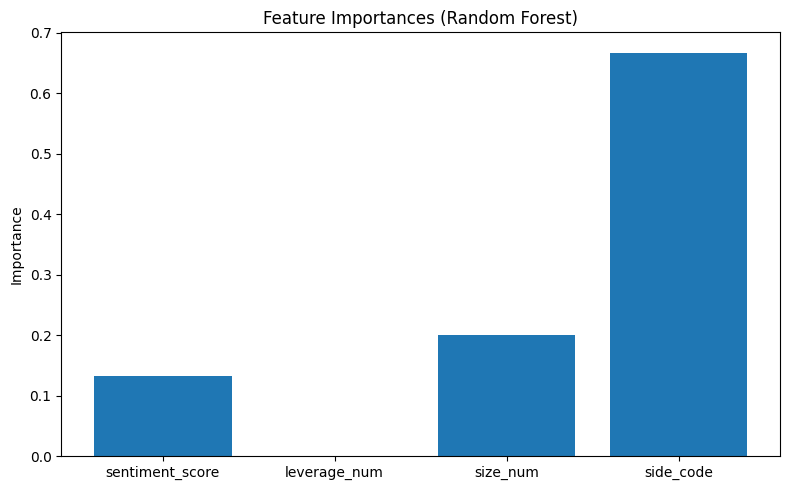

In [ ]:
if len(X) > 20 and y.nunique() > 1:
    importances = rf.feature_importances_
    plt.figure(figsize=(8,5))
    plt.bar(X.columns, importances)
    plt.title("Feature Importances (Random Forest)")
    plt.ylabel("Importance")
    
    plt.tight_layout()
    plt.savefig("outputs/rf_feature_importances.png")
    plt.show()


### Generate PDF Report

In [ ]:
from reportlab.platypus import SimpleDocTemplate, Image, Paragraph, Spacer
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet

doc = SimpleDocTemplate("ds_report.pdf", pagesize=letter)
styles = getSampleStyleSheet()

story = [Paragraph("Trading Sentiment Analysis – Report", styles['Title']), Spacer(1,20)]

for img in os.listdir("outputs"):
    if img.endswith(".png"):
        story.append(Image(f"outputs/{img}", width=500, height=260))
        story.append(Spacer(1,20))

doc.build(story)
print("ds_report.pdf generated successfully!")


ds_report.pdf generated successfully!
